In [1]:
import importlib

import numpy as np
import csv
import os
from time import time, sleep
from tensorflow import keras as ks
import tensorflow as tf 
from tqdm.notebook import tqdm_notebook
from PIL import Image
import splicebuster
from splicebuster.noiseprint import post_em
import splicebuster.main_metrics
#from splicebuster.main_blind_function import extract_heatmap, extract_heatmap_concat
import splicebuster.main_blind_function
#import splicebuster.noiseprint.noiseprint_blind
import splicebuster.noiseprint.noiseprint_blind_concat

from matplotlib import pyplot as plt

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [2]:
importlib.reload(splicebuster.main_metrics)
importlib.reload(splicebuster.main_blind_function)
importlib.reload(splicebuster.noiseprint.noiseprint_blind)
importlib.reload(splicebuster.noiseprint.noiseprint_blind_concat)
importlib.reload(splicebuster.noiseprint.noiseprint)

<module 'splicebuster.noiseprint.noiseprint' from '/project/Code/splicebuster/noiseprint/noiseprint.py'>

In [3]:
main_folder = f"/project"

In [4]:
# Load model
def get_model(modelname, main_folder):
    if modelname == "full":
        model = ks.models.load_model('%s/models/Comprint_Siamese_Full' % main_folder)
    elif modelname == "HighQF2":
        model = ks.models.load_model('%s/models/Comprint_Siamese_HighQF2' % main_folder)
    elif modelname =="HighQF2_rec":
        model = ks.models.load_model('%s/models/Comprint_Siamese_HighQF2_rec' % main_folder)
    elif modelname =="HighQF2_rec_unal":
        model = ks.models.load_model('%s/models/Comprint_Siamese_HighQF2_recompress_unaligned' % main_folder)
    elif modelname =="full_nonSiamese_rec_unal":
        model = ks.models.load_model('%s/models/Comprint_Full_recompress_unaligned' % main_folder)
    elif modelname == "Full_codecs":
        model = ks.models.load_model('%s/models/Comprint_Full_Siamese_codecs' % main_folder)
    elif modelname == "full-jpg-ps":
        model = ks.models.load_model('%s/models/Comprint_Siamese_Full_jpg_ps' % main_folder)
    elif modelname == "full-jpg-ps-full":
        model = ks.models.load_model('%s/models/Comprint_Siamese_Full_jpg_ps_full' % main_folder)
    elif modelname == "net":
        # For noiseprint, load different model depending on jpg QF
        print("Don't load model %s because it's dependent on QF" % modelname)
        noiseprint_model_folder = f"%s/models/noiseprint_nets" % (main_folder)
        model = "%s/%s" % (noiseprint_model_folder, modelname)
        print(model)
    else:
        print("Model %s not found" % modelname)
        model = None
    print("Model %s loaded" % modelname)
    return model



In [5]:
modelnames = ["full"]
#modelnames = ["HighQF2"]
#modelnames = ["HighQF2_rec"]
#modelnames = ["HighQF2_rec_unal"]
#modelnames = ["full_nonSiamese_rec_unal"]
#modelnames = ["Full_codecs"]
modelnames = ["net"]
#modelnames = ["full-jpg-ps"]
modelnames = ["full-jpg-ps-full"]

#modelnames = ["full", "HighQF2"]
#modelnames = ["full", "net"]
#modelnames = ["full", "full-jpg-ps"]
#modelnames = ["full", "full-jpg-ps", "net"]
#modelnames = ["full-jpg-ps-full", "net"]
#modelnames = ["full", "HighQF2_rec_unal", "net"]

In [6]:
save_multiple = False
#save_multiple = True # If concatenation of models, also save individual model heatmap npz files?

In [7]:
models = []
for modelname in modelnames:
    model = get_model(modelname, main_folder)
    models.append(model)

2022-06-16 12:46:05.556542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 12:46:06.620507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3c:00.0, compute capability: 6.1


Model full-jpg-ps-full loaded


# Set input dataset

In [15]:
def get_dataset_folders(dataset_name, main_folder):
    input_folder_real = ""
    output_folder_real = ""
    
    if dataset_name == "VIPP":
        # VIPP Realistic
        input_folder = f"%s/Data/Datasets/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/Forgery" % (main_folder)
        input_folder_real = f"%s/Data/Datasets/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/NonTamp" % (main_folder)
        output_folder = f"%s/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/Forgery" % (main_folder)
        output_folder_real = f"%s/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/NonTamp" % (main_folder)
        ground_truth_folder = f"%s/Data/Datasets/VIPP/VIPP_masks" % (main_folder)
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = False
        
        #output_folder_noiseprint = f"%s/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/Forgery_noiseprint" % (main_folder)
    # VIPP Synthetic
    elif dataset_name == "VIPP_Synthetic":
        input_folder = f"%s/Data/Datasets/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_SyntheticDATASET" % (main_folder)
        # No real folder exists
        output_folder = f"%s/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_SyntheticDATASET" % (main_folder)
        # No real folder exists
        #ground_truth_folder = ""
        ground_truth_folder = f"%s/Data/Datasets/VIPP/TIFS_SyntheticDATASET_gt" % (main_folder)
        ground_truth_file_main = "mask_1024x1024_256x256.png"
        ground_truth_filename_extra = ""
        do_invert = False
    elif dataset_name == "IMD2020":
        # IMD2020
        input_folder = f"%s/Data/Datasets/IMD2020/IMD2020/all" % (main_folder)
        input_folder_real = f"%s/Data/Datasets/IMD2020/IMD2020/all_real" % (main_folder)
        output_folder = f"%s/Data/Datasets_output/IMD2020/IMD2020" % (main_folder)
        output_folder_real = f"%s/Data/Datasets_output/IMD2020/IMD2020_real" % (main_folder)
        ground_truth_folder = f"%s/Data/Datasets/IMD2020/IMD2020/all_masks" % (main_folder)
        ground_truth_file_main = ""
        ground_truth_filename_extra = "_mask"
        do_invert = False
    elif dataset_name == "OpenForensics":
        # OpenForensics
        #input_folder = f"%s/Data/Datasets/OpenForensics/Test-Dev_part1_1" % (main_folder)
        input_folder = f"%s/Data/Datasets/OpenForensics/Test-Dev" % (main_folder)
        # No real folder exists
        #output_folder = f"%s/Data/Datasets_output/OpenForensics/Test-Dev_part1_1" % (main_folder)
        output_folder = f"%s/Data/Datasets_output/OpenForensics/Test-Dev" % (main_folder)
        # No real folder exists
        ground_truth_folder = f"%s/Data/Datasets/OpenForensics/Annotations_GT/Images/Test-Dev" % (main_folder)
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = False
    elif dataset_name == "FaceSwap":
        # FaceSwap
        input_folder = f"%s/Data/Datasets/FaceSwap_jpg/fake" % (main_folder)
        input_folder_real = f"%s/Data/Datasets/FaceSwap_jpg/real" % (main_folder)
        output_folder = f"%s/Data/Datasets_output/FaceSwap_jpg/fake" % (main_folder)
        output_folder_real = f"%s/Data/Datasets_output/FaceSwap_jpg/real" % (main_folder)
        ground_truth_folder = f"%s/Data/Datasets/FaceSwap_jpg/mask" % (main_folder)
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = False
    elif dataset_name == "DSO-1":
        input_folder = f"%s/Data/Datasets/DSO-1/splicing" % (main_folder)
        input_folder_real = f"%s/Data/Datasets/DSO-1/normal" % (main_folder)
        output_folder = f"%s/Data/Datasets_output/DSO-1/splicing" % (main_folder)
        output_folder_real = f"%s/Data/Datasets_output/DSO-1/normal" % (main_folder)
        ground_truth_folder = f"%s/Data/Datasets/DSO-1/masks" % (main_folder)
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = True
    elif dataset_name == "websplicing100":
        # FaceSwap
        input_folder = f"%s/Data/Datasets/splicing100_facebook_L/fake" % (main_folder)
        input_folder_real = f"%s/Data/Datasets/splicing100_facebook_L/real" % (main_folder) # doesn't exist
        output_folder = f"%s/Data/Datasets_output/splicing100_facebook_L/fake" % (main_folder)
        output_folder_real = f"%s/Data/Datasets_output/splicing100_facebook_L/real" % (main_folder)
        ground_truth_folder = f"%s/Data/Datasets/splicing100_facebook_L/mask" % (main_folder)  # doesn't exist
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = False
    elif dataset_name == "Random_tests":
        input_folder = f"%s/Data/Datasets/Random_tests" % (main_folder)
        #input_folder = f"%s/Data/Datasets/Random_tests/imagen" % (main_folder)
        input_folder_real = ""
        output_folder = f"%s/Data/Datasets_output/Random_tests" % (main_folder)
        #output_folder = f"%s/Data/Datasets_output/Random_tests/imagen" % (main_folder)
        output_folder_real = ""
        ground_truth_folder = ""
        ground_truth_file_main = ""
        ground_truth_filename_extra = ""
        do_invert = False
    else:
        print("Dataset %s not found" % dataset_name)
        return "", "", "", "", "", False
        
    return input_folder, input_folder_real, output_folder, output_folder_real, ground_truth_folder, ground_truth_file_main, ground_truth_filename_extra, do_invert

In [16]:
dataset_name = "VIPP"
#dataset_name = "VIPP_Synthetic"
dataset_name = "IMD2020"
dataset_name = "OpenForensics"
#dataset_name = "FaceSwap"
#dataset_name = "DSO-1"
#dataset_name = "websplicing100"
dataset_name = "Random_tests"

In [17]:
# Optional: to read which files to analyze from file
#input_files_filename = f"%s/Data/Datasets_output/OpenForensics/%s" % (main_folder, "OpenForensics_errors.txt")
#input_files_filename = f"%s/Data/Datasets_output/OpenForensics/%s" % (main_folder, "OpenForensics_errors_npz_missing.txt")

In [18]:
# Get dataset info
input_folder, input_folder_real, output_folder, output_folder_real, ground_truth_folder, ground_truth_file_main, ground_truth_filename_extra, do_invert = get_dataset_folders(dataset_name, main_folder)

print(input_folder)
print(input_folder_real)
print(output_folder)
print(output_folder_real)
print(ground_truth_folder)

/project/Data/Datasets/Random_tests

/project/Data/Datasets_output/Random_tests




In [19]:
do_fake = True
#do_fake = False # Real

# Bulk detection

In [20]:
def get_filenames(input_folder, input_filename, output_folder, modelnames, ground_truth_filename_extra, ground_truth_folder, ground_truth_file_main, save_heatmap, save_multiple=False):
    # Set correct filenames
    input_filename_wo_ext = os.path.splitext(input_filename)[0]
    input_file = f"%s/%s" % (input_folder, input_filename)

    fingerprint_files = []
    output_filename_base = "%s" % (input_filename)
    output_file_base = f"%s/%s" % (output_folder, output_filename_base)
    output_filename = output_filename_base
    if len(modelnames) > 1:
        output_filename = "%s_concat" % output_filename_base

    output_files = []
    output_files_npz = []
    heatmap_files = []
    for modelname in modelnames:
        fingerprint_file = f"%s_%s_res.png" % (output_file_base, modelname)
        fingerprint_files.append(fingerprint_file)
        
        # Build concatenated filename
        output_filename = "%s_%s" % (output_filename, modelname)
        
        if save_multiple: # Individual output files
            output_file = f"%s/%s_%s" % (output_folder, output_filename_base, modelname)
            output_files.append(output_file)
            output_file_npz = f"%s.npz" % (output_file)
            output_files_npz.append(output_file_npz)

            if save_heatmap:
                heatmap_file = f"%s_heatmap.png" % (output_file)
            else:
                heatmap_file = ""
            heatmap_files.append(heatmap_file)
        

    output_file = f"%s/%s" % (output_folder, output_filename)
    output_files.append(output_file)
    
    output_file_npz = f"%s.npz" % (output_file)
    output_files_npz.append(output_file_npz)
    
    if save_heatmap:
        heatmap_file = f"%s_heatmap.png" % (output_file)
    else:
        heatmap_file = ""
    heatmap_files.append(heatmap_file)
    
    # Extra for metrics:
    ground_truth_filename = f"%s%s.png" % (input_filename_wo_ext, ground_truth_filename_extra)

    if ground_truth_folder:
        if ground_truth_file_main:
            ground_truth_file = f"%s/%s" % (ground_truth_folder, ground_truth_file_main)
        else:
            ground_truth_file = f"%s/%s" % (ground_truth_folder, ground_truth_filename)
    else:
        ground_truth_file = ""
    
    return input_file, output_files, fingerprint_files, output_files_npz, ground_truth_file, heatmap_files

def get_multiple_models(modelnames, save_multiple):
    if save_multiple and len(modelnames) > 0:
        multiple_models = []
        for modelname in modelnames:
            multiple_models.append([modelname])
        multiple_models.append(modelnames) # concatenated version
        return multiple_models
    else:
        return [modelnames] # don't do multiple models
    
def get_csv_file(main_folder, dataset_name, modelnames, version):
    csv_filename = "results_%s" % (dataset_name)
    if len(modelnames) > 1:
        csv_filename = "%s_concat" % csv_filename

    for modelname in modelnames:
        csv_filename = "%s_%s" % (csv_filename, modelname)

    csv_filename = "%s_%s.csv" % (csv_filename, version)

    results_csv_folder = f"%s/Data/Datasets_output/csv" % main_folder
    csv_file = "%s/%s" % (results_csv_folder, csv_filename)
    ensure_dir(csv_file)
    return csv_file

In [21]:
if do_fake:
    print("Fake images")
    input_folder_to_evaluate = input_folder
    output_folder_to_evaluate = output_folder
else: # do real folder
    print("Real images")
    input_folder_to_evaluate = input_folder_real
    output_folder_to_evaluate = output_folder_real

Fake images


In [48]:
input_folder_files = os.listdir(input_folder_to_evaluate)
print("Folder: %s" % input_folder_to_evaluate)
print("Nr. of files found: %d" % len(input_folder_files))

index_from = 0
index_to = len(input_folder_files)

Folder: /project/Data/Datasets/Random_tests
Nr. of files found: 31


### Some optional code to select images

In [34]:
#input_files_filename = "/project/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/VIPP_full-jpg-ps-full_errors.txt"
input_files_filename = "/project/Data/Datasets_output/VIPP/DEMPSTER_SHAFER_FORENSICS/TIFS_RealisticDATASET/VIPP_full-jpg-ps-full_errors.txt"

In [35]:
# Alternative, read from file with filenames line by line:
with open(input_files_filename, "r") as input_files_file:
    input_folder_files = input_files_file.read().splitlines()
    
print("Nr. of files found: %d" % len(input_folder_files))

Nr. of files found: 26


In [36]:
print(input_folder_files)

['Forgery_bullock.jpg', 'Forgery_DPP8_TIFF0396_final.jpg', 'Forgery_DSC_7745_edited.jpg', 'Forgery_final 10.jpg', 'Forgery_final 11.jpg', 'Forgery_final 12.jpg', 'Forgery_final 13.jpg', 'Forgery_final 14.jpg', 'Forgery_final 15.jpg', 'Forgery_final 16.jpg', 'Forgery_final 17.jpg', 'Forgery_final 2.jpg', 'Forgery_final 3.jpg', 'Forgery_final 4.jpg', 'Forgery_final 5.jpg', 'Forgery_final 6.jpg', 'Forgery_final 7.jpg', 'Forgery_final 8.jpg', 'Forgery_final 9.jpg', 'Forgery_final copia 2.jpg', 'Forgery_final.jpg', 'Forgery_final copia.jpg', 'Forgery_JPGAllin_1.jpg', 'Forgery_JPGDisall_1.jpg', 'Forgery_keira.jpg', 'Forgery_mercedes.jpg']


In [16]:
# Check indexes
input_folder_files[8500:8501]

['9f5057f155.jpg']

In [38]:
begin = 10000
end = -1
for i, file in enumerate(input_folder_files[begin:]):
    f = "/project/Data/Datasets_output/OpenForensics/Test-Dev/%s_concat_full-jpg-ps-full_net.npz" % file
    if not os.path.exists(f):
        print("%d does not exist: %s" % (begin+i, f))
    else:
        print("%d does exist!" % (begin+i), end="\r")

17904 does not exist: /project/Data/Datasets_output/OpenForensics/Test-Dev/e7265fb8f9.jpg_concat_full-jpg-ps-full_net.npz


In [49]:
# Check indexes
#i = input_folder_files.index("25683335783_e9776d1dc2_o_25113756266_fa33a41372_o.jpg")
#i = input_folder_files.index("39e9dc4240.jpg")
#i = input_folder_files.index("9b654dff44.jpg")
#i = input_folder_files.index("eaf1f7c59a.jpg")
#i = input_folder_files.index("facehub_jack-sparrow_hannes_crop.png")
#i = input_folder_files.index("13959892318_c4214fb287_o.jpg")
#i = input_folder_files.index("3607118426_3ea7c46269_o_3158822245_1130581249_o.jpg")
#i = input_folder_files.index("6ac18f295d.jpg")
#i = input_folder_files.index("dca19276cd.jpg")
#i = input_folder_files.index("c428039e46.jpg")
i = input_folder_files.index("BeforeVsAfter-2.png")
#i = input_folder_files.index("BeforeVsAfter-2-onlyBefore.png")
#i = input_folder_files.index("BeforeVsAfter-2-onlyAfter.png")


print(i)
index_from = i
index_to = index_from+1

30


In [28]:
#input_folder_files = ["6ac18f295d.jpg"]
input_folder_files = ["e0c84c5f54.jpg"]

In [29]:
# Optional: only select subset
index_from = 0
#index_from = 7113
#index_to = 
index_to = len(input_folder_files)
#index_to = 1
#index_to = 7113+1

### Analysis code again

In [30]:
save_fingerprint = False
save_fingerprint = True

res_to_concat_filenames = []

In [50]:
tt = time()
input_folder_files_len = len(input_folder_files)
for i, input_filename in enumerate(input_folder_files[index_from:index_to]):
    print(f'\nProcessing %d/%d: %s' % (i+index_from, input_folder_files_len, input_filename))

    # Set correct filenames
    input_file, output_files, fingerprint_files, output_files_npz, ground_truth_file, heatmap_files = get_filenames(input_folder_to_evaluate, input_filename, output_folder_to_evaluate, modelnames, ground_truth_filename_extra, ground_truth_folder, ground_truth_file_main, False, save_multiple)
    
    succeeded = False
    tries = 0
    max_tries = 1 # extract_heatmap sometimes fails randomly, so try multiple times
    while not succeeded and tries < max_tries:
        try:
            t = time()
            if save_fingerprint:
                splicebuster.main_blind_function.extract_heatmap_concat_multiple(input_file, output_files, models, res_to_concat_filenames, fingerprint_files, save_multiple=save_multiple)
            else:
                splicebuster.main_blind_function.extract_heatmap_concat_multiple(input_file, output_files, models, res_to_concat_filenames, save_multiple=save_multiple)

            elapsed_time = time() - t
            print(f"Finished in %f seconds" % elapsed_time)
            succeeded = True
        except Exception as e:
            print("Error!")
            print(e)
            tries = tries + 1
            sleep(2) # Sleep 2 seconds

total_elapsed_time = time() - tt
print("Total time: %f" % total_elapsed_time)


Processing 30/31: BeforeVsAfter-2.png
Finished in 22.996026 seconds
Total time: 22.997505


# Generate csv with localization metrics (MCC, AP, F1)

In [51]:
# Optional: only select subset
index_from_metrics = index_from
index_to_metrics = index_to
#index_from_metrics = 0
#index_to_metrics = len(input_folder_files)

In [52]:
save_heatmap = False
save_heatmap = True

In [53]:
version = "20220616-0"
#version = "exp"

csv_file = get_csv_file(main_folder, dataset_name, modelnames, version)
print(csv_file)

/project/Data/Datasets_output/csv/results_Random_tests_full-jpg-ps-full_20220616-0.csv


In [54]:
multiple_models = get_multiple_models(modelnames, save_multiple)
for m_i, modelname in enumerate(multiple_models):
    print(m_i, modelname)
    csv_file = get_csv_file(main_folder, dataset_name, modelname, version)
    print(csv_file)

0 ['full-jpg-ps-full']
/project/Data/Datasets_output/csv/results_Random_tests_full-jpg-ps-full_20220616-0.csv


In [55]:
multiple_models = get_multiple_models(modelnames, save_multiple)
for m_i, modelname in enumerate(multiple_models):
    #if len(multiple_models) == 0 or modelname != "net":
    if True:
        print(m_i, modelname)
        csv_file = get_csv_file(main_folder, dataset_name, modelname, version)
        print(csv_file)

        tt = time()
        input_folder_files_len = len(input_folder_files)

        errors = []
        with open(csv_file, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            writer.writerow(['file', 'MCC', 'AP', 'F1'])

            for i, input_filename in enumerate(input_folder_files[index_from_metrics:index_to_metrics]):
                print(f'\nProcessing %d/%d: %s' % (i+index_from_metrics, input_folder_files_len, input_filename))

                # Set correct filenames
                input_file, output_files, fingerprint_files, output_files_npz, ground_truth_file, heatmap_files = get_filenames(input_folder_to_evaluate, input_filename, output_folder_to_evaluate, modelnames, ground_truth_filename_extra, ground_truth_folder, ground_truth_file_main, save_heatmap, save_multiple)

                output_file = output_files[m_i]
                output_file_npz = output_files_npz[m_i]
                heatmap_file = heatmap_files[m_i]

                try:
                    mcc, ap, f1 = splicebuster.main_metrics.detection_metrics(ground_truth_file, output_file_npz, heatmap_filename=heatmap_file, do_invert=do_invert)
                except Exception as e:
                    mcc, ap, f1 = np.nan, np.nan, np.nan
                    error = (i, input_filename, e)
                    print(error)
                    errors.append(error)

                print("%s, %s, %s, %s" % (input_filename, mcc, ap, f1))
                if ground_truth_folder:
                    writer.writerow([input_filename, mcc, ap, f1])

        total_elapsed_time = time() - tt
        print("Total time: %f" % total_elapsed_time)

        if len(errors) > 0:
            print("Errors: %d" % len(errors))
            print(errors)

0 ['full-jpg-ps-full']
/project/Data/Datasets_output/csv/results_Random_tests_full-jpg-ps-full_20220616-0.csv

Processing 30/31: BeforeVsAfter-2.png
Heatmap saved to /project/Data/Datasets_output/Random_tests/BeforeVsAfter-2.png_full-jpg-ps-full_heatmap.png
BeforeVsAfter-2.png, nan, nan, nan
Total time: 0.824453


# Generate csv with detection metrics (AUC)

In [16]:
import os
import pandas

from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score, roc_curve

import sys

In [26]:
operations = {
    'mean'   : np.nanmean,
    'median' : np.nanmedian,
    'std'    : np.nanstd,
    'max'    : lambda x : np.nanmax(x),
    'perc750': lambda x : np.nanpercentile(x, 75.0),
    'perc900': lambda x : np.nanpercentile(x, 90.0),
    'perc950': lambda x : np.nanpercentile(x, 95.0),
    'perc960': lambda x : np.nanpercentile(x, 96.0),
    'perc970': lambda x : np.nanpercentile(x, 97.0),
    'perc975': lambda x : np.nanpercentile(x, 97.5),
    'perc980': lambda x : np.nanpercentile(x, 98.0),
    'perc985': lambda x : np.nanpercentile(x, 98.5),
    'perc990': lambda x : np.nanpercentile(x, 99.0),
    'perc995': lambda x : np.nanpercentile(x, 99.5),
}

#operations = {
#    'mean'   : np.nanmean
#}

ops_to_save = [
    'mean', 
    'median', 
    'std', 
    'max', 
    'perc975',
    'perc995'
]

#ops_to_save = operations


#num_threads = 1
#num_threads = 2
num_threads = 4

find_best_threshold = True
#find_best_threshold = False

In [18]:
def pd_at_far(y_true, y_score, tnr_th=0.9):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    return np.interp(1.0-tnr_th, fpr, tpr)

#def extract_global_features(input_folder, input_filename, output_folder, modelnames, operations):
def extract_global_features(input_folder_to_eval, input_filename, output_folder_to_eval):
    # Treat modelnames and operations as global unchanging variables
    try:
        # Set correct filenames
        input_file, output_files, fingerprint_files, output_files_npz, ground_truth_file, heatmap_files = get_filenames(input_folder_to_eval, input_filename, output_folder_to_eval, modelnames, "", "", "", False, False)
        output_file = output_files[0]
        
        # Load heatmap npz file
        output_file += ".npz"
        #try:
        map = np.load(output_file)['map']
        #except ValueError:
            #map = np.load(output_file, allow_pickle=True)['map']
        #print(map.files)
        
        # Apply all operations
        results = list()
        for o, op in enumerate(operations):
            try:
                results.append(operations[op](map)) # extracts global features (max, mean, ...)
            except Exception as e:
                error = (output_file, e)
                print(error)
                results.append(np.nan)
        return results

    except Exception as e:
        error = (input_filename, output_file, e)
        print(error)
        return [np.nan]*len(operations)

In [48]:
# Detection in the name for these
version = "detection_20220517-0"

csv_file = get_csv_file(main_folder, dataset_name, modelnames, version)
print(csv_file)

/project/Data/Datasets_output/csv/results_FaceSwap_concat_full-jpg-ps-full_net_detection_20220517-0.csv


In [49]:
# Input files (real and fake)
input_folder_real_files = os.listdir(input_folder_real)
input_folder_fake_files = os.listdir(input_folder)

labels_real = [0] * len(input_folder_real_files)
labels_fake = [1] * len(input_folder_fake_files)
labels = labels_real + labels_fake

# Do it all with multithreading pools
args_real = [(input_folder_real, input_filename, output_folder_real) for input_filename in input_folder_real_files]
args_fake = [(input_folder, input_filename, output_folder) for input_filename in input_folder_fake_files]
args = args_real + args_fake

# Map images to thread jobs
with Pool(num_threads) as p:
    res = list(tqdm(p.starmap(extract_global_features, args), total=(len(input_folder_real_files) + len(input_folder_fake_files)), leave=False))
    res = np.asarray(res) # rows: images;   columns: operations

('21223585073_0bee5cee6f_o.jpg', '/project/Data/Datasets_output/FaceSwap_jpg/real/21223585073_0bee5cee6f_o.jpg_concat_full-jpg-ps-full_net.npz', FileNotFoundError(2, 'No such file or directory'))
('14848702261_34f0465251_o.jpg', '/project/Data/Datasets_output/FaceSwap_jpg/real/14848702261_34f0465251_o.jpg_concat_full-jpg-ps-full_net.npz', FileNotFoundError(2, 'No such file or directory'))
('21643788133_f600c411e6_o.jpg', '/project/Data/Datasets_output/FaceSwap_jpg/real/21643788133_f600c411e6_o.jpg_concat_full-jpg-ps-full_net.npz', FileNotFoundError(2, 'No such file or directory'))
('22845693169_72ae4da6a7_o.jpg', '/project/Data/Datasets_output/FaceSwap_jpg/real/22845693169_72ae4da6a7_o.jpg_concat_full-jpg-ps-full_net.npz', FileNotFoundError(2, 'No such file or directory'))
('10003456176_d0a42279b1_o.jpg', '/project/Data/Datasets_output/FaceSwap_jpg/real/10003456176_d0a42279b1_o.jpg_concat_full-jpg-ps-full_net.npz', FileNotFoundError(2, 'No such file or directory'))
('23241487024_10c416

  0%|          | 0/2530 [00:00<?, ?it/s]

In [50]:
print(len(res))
print(res)

2530
[[7.24179582e+02 5.00197230e+01 4.15649194e+03 ... 2.41913628e+04
  2.41913628e+04 2.41913628e+04]
 [9.04316445e+03 4.61375082e+01 3.99890910e+04 ... 2.31333613e+05
  2.31333613e+05 2.31333613e+05]
 [3.50416945e+03 1.77602673e+02 6.71772233e+03 ... 2.32881731e+04
  2.36138030e+04 2.40461133e+04]
 ...
 [8.86267960e+01 4.39518453e+01 7.23225027e+02 ... 1.90479486e+02
  2.17592821e+02 3.82499749e+02]
 [           nan            nan            nan ...            nan
             nan            nan]
 [3.44453456e+02 3.61426576e+02 2.69183481e+02 ... 1.04582464e+03
  1.15503462e+03 1.47829496e+03]]


too many nans
too many nans
too many nans
too many nans
too many nans
too many nans
too many nans
too many nans
too many nans
too many nans


/tmp/ipykernel_328/2292990708.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pandas.Series(dtype='object'), ignore_index=True)    # new empty row for the algorithm


too many nans
too many nans
too many nans
too many nans
best accuracy: 0.5292759794915944 with threshold 6389.059226516624


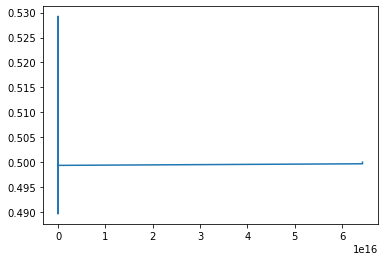

,AUC_mean,AUC_median,AUC_max,AUC_perc975,AUC_perc995,best_AUC,pd_best_AUC,skipped
0,0.508,0.426,0.53,0.494,0.532,0.532,0.139,137


In [51]:
# Calculate ROC from results
# CSV Header
columns = []
for op in ops_to_save:
    columns.append('AUC_' + op)  # AUC
    columns.append('pd_'  + op)  # pd@10%
columns += ['best_AUC', 'pd_best_AUC','skipped']
df = pandas.DataFrame(columns=columns)
df = df.append(pandas.Series(dtype='object'), ignore_index=True)    # new empty row for the algorithm

max_skipped  = 0
AUCs, pds, ROCs = [], [], []

try:
    for op_i, op in enumerate(operations):
        scores = np.copy(res[:,op_i])  # column of the operation
        scores[scores==np.PINF] = np.nanmax(scores[scores<np.PINF])

        skipped = len(scores[~np.isfinite(scores)])  # just to check how many misses

        if skipped > max_skipped:
            max_skipped = skipped  # we could have a different number of misses for each operation
        if skipped < 50:
            scores[np.isnan(scores)] = np.nanmin(scores) # we only replace nans if there are few of them
        else:
            print('too many nans')

        lbl = np.array(labels)
        lbl = lbl[np.isfinite(scores)]
        scores = scores[np.isfinite(scores)]
        assert lbl.shape == scores.shape

        # METRICS
        auc = np.round( roc_auc_score(lbl, scores), 3)
        pd  = np.round( pd_at_far(lbl, scores),     3)

        if find_best_threshold:
            fpr_, tpr_, th_ = roc_curve(lbl, scores)
            ROCs.append((fpr_,tpr_,th_))

        if op != 'std':
            AUCs.append(auc)    # this is for finding the best AUC over the different operations
            pds.append(pd)

        if op in ops_to_save:
            df['AUC_' + op].iloc[-1] = auc
            df['pd_'  + op].iloc[-1] = pd

    best_AUC = np.max(AUCs)
    best_AUC_index = np.argmax(AUCs)
    best_pd  = pds[best_AUC_index]

    df['best_AUC'   ].iloc[-1] = best_AUC
    df['pd_best_AUC'].iloc[-1] = best_pd            
    df['skipped'    ].iloc[-1] = max_skipped

    if find_best_threshold:
        (fpr, tpr, th) = ROCs[best_AUC_index]  # I am only doing it for the best ROC
        acc = (tpr-fpr+1)/2
        print(f'best accuracy: {np.max(acc)} with threshold {th[np.argmax(acc)]}')
        plt.plot(th, acc)
        plt.show()

    df.to_csv(csv_file, header='true', index=False, sep=';')

except:
    import traceback
    traceback.print_exc()
    pass

display(df[['AUC_mean','AUC_median','AUC_max','AUC_perc975','AUC_perc995','best_AUC','pd_best_AUC','skipped']])